# Dependencies

In [27]:
import os
import logging
import zipfile
import requests
import numpy as np
import tensorflow as tf
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tensorboard import notebook


# Word2VecModel Module

In [53]:
"""
Word2Vec Model Module

This module provides functionality to download, load, and interact with a Word2Vec model using a given vocabulary list.
It includes methods to get the vocabulary size, find the most similar words, and retrieve word vectors.

Classes:
--------
Word2VecModel
    A class to encapsulate the functionality of the Word2Vec model using a vocabulary list.

Functions:
----------
test_word2vec_model
    Tests the Word2VecModel class.
"""

# Logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Word2VecModel:
    """
    A class to encapsulate the functionality of the Word2Vec model using a vocabulary list.

    Attributes:
    -----------
    model : KeyedVectors
        The loaded Word2Vec model.
    vocab : list
        The vocabulary list.
    """

    def __init__(self, vocab):
        """
        Initializes the Word2VecModel class with a vocabulary list.

        Parameters:
        -----------
        vocab : list
            The vocabulary list.
        """
        self.vocab = vocab
        self.model = self._load_model()

    def _download_and_extract_model(self, url, extract_to='.'):
        """
        Downloads and extracts the Word2Vec model.

        Parameters:
        -----------
        url : str
            The URL of the zip file containing the Word2Vec model.
        extract_to : str
            The directory to extract the zip file to.
        """
        local_zip_file = "w2v.vectors.zip"

        logging.info(f"Downloading the model from {url}...")
        # Download the zip file
        response = requests.get(url)
        with open(local_zip_file, 'wb') as f:
            f.write(response.content)

        logging.info("Extracting the zip file...")
        # Extract the zip file
        with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        logging.info("Model downloaded and extracted successfully.")

    def _load_model(self):
        """
        Loads the Word2Vec model from a temporary file.

        Returns:
        --------
        KeyedVectors
            The loaded Word2Vec model.
        """
        model_dir = os.path.join(os.getcwd(), 'models')
        model_file = os.path.join(model_dir, 'w2v.vectors.kv')

        if not os.path.exists(model_file):
            os.makedirs(model_dir, exist_ok=True)
            self._download_and_extract_model(
                'https://github.com/rdenadai/WordEmbeddingPortugues/releases/download/0.5/w2v.vectors.zip',
                extract_to=model_dir
            )

        logging.info("Loading the Word2Vec model...")
        model = KeyedVectors.load(model_file, mmap='r')
        logging.info("Model loaded successfully.")
        return model

    def get_vocab_size(self):
        """
        Returns the size of the vocabulary.

        Returns:
        --------
        int
            The size of the vocabulary.
        """
        return len(self.vocab)

    def most_similar(self, word, topn=3):
        """
        Finds the most similar words for a given word.

        Parameters:
        -----------
        word : str
            The word to find the most similar words for.
        topn : int, optional
            The number of most similar words to return (default is 3).

        Returns:
        --------
        list of tuples
            A list of tuples containing the most similar words and their similarities.
        """
        return self.model.most_similar(word, topn=topn)

    def display_similar_words(self, words, topn=3):
        """
        Displays the most similar words for a given list of words.

        Parameters:
        -----------
        words : list
            The list of words to find the most similar words for.
        topn : int, optional
            The number of most similar words to return (default is 3).
        """
        for word in words:
            print(f"\n{word}:")
            print("-" * 28)
            similar_words = self.most_similar(word, topn=topn)
            for similar_word, similarity in similar_words:
                print(f"{similar_word:<20} {similarity:.5f}")

    def get_vector(self, word):
        """
        Returns the vector for a given word.

        Parameters:
        -----------
        word : str
            The word to get the vector for.

        Returns:
        --------
        numpy.ndarray
            The vector corresponding to the given word.
        """
        if word in self.model:
            return self.model[word]
        else:
            logging.warning(f"The word '{word}' is not in the vocabulary.")
            return None

    def get_sentence_embedding(self, sentence):
        if isinstance(sentence, str):
            embeddings = [self.get_vector(word) for word in sentence.split(',') if self.get_vector(word) is not None]
            return np.mean(embeddings, axis=0) if embeddings else np.zeros(self.model.vector_size)
        else:
            return np.zeros(self.model.vector_size)

    def save_embeddings_for_projector(self, output_dir='embeddings', metadata_file='metadata.tsv'):
        """
        Saves the embeddings and metadata to files for use with TensorFlow's Embedding Projector.

        Parameters:
        -----------
        output_dir : str
            Directory to save the embedding and metadata files.
        metadata_file : str
            The file name for metadata.
        """
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save embeddings
        embeddings = np.array([self.get_vector(word) for word in self.vocab if self.get_vector(word) is not None])
        np.save(os.path.join(output_dir, 'embeddings.npy'), embeddings)

        # Save metadata
        with open(os.path.join(output_dir, metadata_file), 'w') as f:
            for word in self.vocab:
                if self.get_vector(word) is not None:
                    f.write(f"{word}\n")

        logging.info(f"Embeddings and metadata saved to {output_dir}.")

# Tests

In [3]:
# Automated tests
def test_word2vec_model():
    """
    Tests the Word2VecModel class.
    """
    # Example vocabulary list
    vocab = [
        "preto", "branco", "pássaro", "lobo", "mulher",
        "masculino", "sexo", "montanha", "oceano", "lua",
        "amor", "senhor", "cimegripe", "nimesulida", "médico",
        "doença", "coração", "febre", "dor", "coriza",
        "rancor", "mau", "ódio", "braço", "maçã", "coco",
        "lobo mau", "espada", "cavaleiro", "rei", "arthur",
        "rei arthur"
    ]

    # Initialize the model
    w2v_model = Word2VecModel(vocab)

    # Test vocabulary size
    assert w2v_model.get_vocab_size() == len(vocab), "Vocabulary size should match the number of words in the list"

    # Test most_similar function
    similar_words = w2v_model.most_similar("preto")
    assert len(similar_words) == 3, "Should return 3 most similar words"

    # Test get_vector function
    vector = w2v_model.get_vector("preto")
    assert vector is not None, "Vector for the word 'preto' should not be None"
    assert isinstance(vector, np.ndarray), "Vector should be an instance of numpy.ndarray"

    print("All tests passed successfully!")

# Run tests
test_word2vec_model()

All tests passed successfully!


# Usage examples

In [4]:
# Example vocabulary list
vocab = [
    "preto", "branco", "pássaro", "lobo", "mulher",
    "masculino", "sexo", "montanha", "oceano", "lua",
    "amor", "senhor", "cimegripe", "nimesulida", "médico",
    "doença", "coração", "febre", "dor", "coriza",
    "rancor", "mau", "ódio", "braço", "maçã", "coco",
    "lobo mau", "espada", "cavaleiro", "rei", "arthur",
    "rei arthur"
]

# Initialize the model
w2v_model = Word2VecModel(vocab)

## Get and display the vector for a specific word

In [5]:
word = "brasil"
vector = w2v_model.get_vector(word)
if vector is not None:
    print(f"\nVector for the word '{word}':")
    print(vector)


Vector for the word 'brasil':
[ 0.5970225   0.1118112  -0.01843474 -0.39452755 -0.64651304  0.54044616
 -0.6313759   0.40586674 -0.02060019 -0.36727065 -0.22503066 -0.24287668
  0.04649599 -0.20327091 -0.26815814  0.44818205  0.00877269 -0.15585396
 -0.5720233   0.18782504 -0.24567819 -0.5618444   0.4485593  -0.28840002
 -0.8688128  -0.18713732 -0.3503491  -0.10794832  0.02672527 -0.24257854
 -0.36994898  0.23282573 -0.2929671  -0.1368056  -0.01091119 -0.25049177
 -0.09747729 -0.41028693  0.02767042 -0.12092518  0.04240586 -0.18626358
  0.21183486  0.04510147 -0.30812556 -0.14280568  0.0143995  -0.11503907
  0.41845477 -0.01085946  0.16987993  0.6869112  -0.06492797 -0.3082485
 -0.06752153 -0.14372078 -0.16444328 -0.02552564  0.28134614  0.05729644
  0.93909794 -0.5869509  -0.34123272 -0.27032992 -0.14500283  0.11687621
 -0.07714742 -0.7656599   0.17841214  0.44181964  0.01591188  0.00288681
 -0.31993458 -0.31287524  0.5828172   0.6004061   0.24517286 -0.4834124
 -0.35969517  0.173513

## Display the most similar words

In [6]:
w2v_model.display_similar_words(["preto", "branco", "pássaro", "lobo", "mulher"])


preto:
----------------------------
branco               0.79271
dourado              0.75473
cinza                0.75170

branco:
----------------------------
branca               0.79388
preto                0.79271
roxo                 0.75019

pássaro:
----------------------------
pássaros             0.77602
rouxinol             0.76595
hipopótamo           0.76495

lobo:
----------------------------
lobos                0.68262
grilo                0.67680
cervo                0.65533

mulher:
----------------------------
homem                0.81129
menina               0.78433
mulheres             0.78332


## Display the number of tokens in the model

In [7]:
print(f"Tokens: {len(w2v_model.model.key_to_index)}")

Tokens: 981032


# Ponderada

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import logging
import os
from gensim.models import KeyedVectors

In [10]:
# Carregar os dados
path_database = "/content/processed_data.xlsx"
df = pd.read_excel(path_database)

# Label Encoding da coluna 'intention'
label_encoder = LabelEncoder()
df['intention_encoded'] = label_encoder.fit_transform(df['intention'])

In [11]:
df = df.drop(columns=['intention', 'question'])

In [12]:
df.head(20)

,processed_question,intention_encoded
0,"diatudo,bemeu,gostar,caixa,family,Mart,verde,e...",4
1,"enviar,dinheiro,Japão",5
2,"levar,beneficiário,receber,dinheiro",16
3,"acabar,transferência, ,total,Yenes",9
4,"poder,remesso,yenes,bbb,rrr, ,yenes,Aaaa,Mm...",9
5,"acabar,transferência,contar, ,descontar,taxa",9
6,"beneficiár,yyy,fff,yyy",9
7,"inscrever,serviço,remesso",6
8,"noite,gostar,tirar,dúvidapq,cotação,dólar, ,app",7
9,"dia,hoje,fiz,depósito,achar,esqueci,digitar,có...",9


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2162 - loss: 2.7494 - val_accuracy: 0.3564 - val_loss: 2.2968
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3104 - loss: 2.3576 - val_accuracy: 0.3960 - val_loss: 2.0906
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3663 - loss: 2.2319 - val_accuracy: 0.4356 - val_loss: 1.9151
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3765 - loss: 2.0290 - val_accuracy: 0.4950 - val_loss: 1.7892
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4074 - loss: 2.0058 - val_accuracy: 0.4950 - val_loss: 1.6627
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4469 - loss: 1.8376 - val_accuracy: 0.5545 - val_loss: 1.5968
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4700 - loss: 1.7089 - val_accuracy: 0.6139 - val_loss: 1.5003
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5090 - loss: 1.6061 - val_accuracy: 0.5842 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


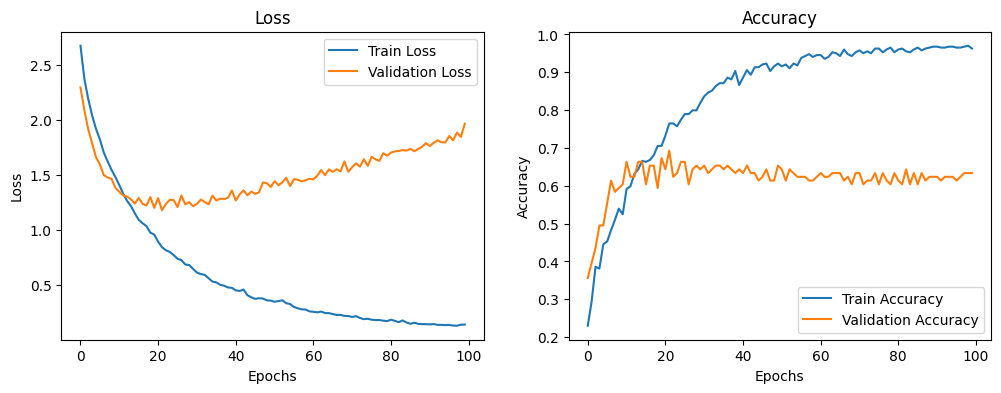

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8936 - loss: 0.4801 - val_accuracy: 0.8416 - val_loss: 0.6333
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9011 - loss: 0.4050 - val_accuracy: 0.8614 - val_loss: 0.5301
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9363 - loss: 0.2452 - val_accuracy: 0.8812 - val_loss: 0.4638
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9407 - loss: 0.2424 - val_accuracy: 0.8911 - val_loss: 0.4067
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9463 - loss: 0.1951 - val_accuracy: 0.8515 - val_loss: 0.4653
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9511 - loss: 0.2137 - val_accuracy: 0.8911 - val_loss: 0.3952
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9583 - loss: 0.1667 - val_accuracy: 0.8960 - val_loss: 0.3303
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9637 - loss: 0.1553 - val_accuracy: 0.9109 

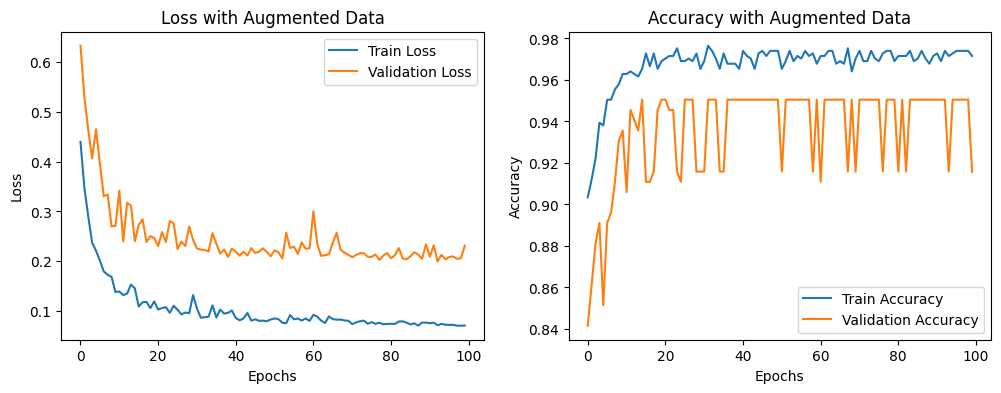

In [21]:
from sklearn.metrics import recall_score, f1_score

# Função para obter embeddings usando Word2Vec
def get_word2vec_embeddings(text):
    if isinstance(text, str):
        embeddings = [word2vec_model.get_vector(word) for word in text.split(',') if word2vec_model.get_vector(word) is not None]
        return np.mean(embeddings, axis=0) if embeddings else np.zeros(word2vec_model.model.vector_size)
    else:
        return np.zeros(word2vec_model.model.vector_size)

# Função para aumentar os dados
def augment_data(text):
    if isinstance(text, str):
        words = text.split(',')
        np.random.shuffle(words)
        return ','.join(words)
    else:
        return text

# Supondo que processed_question e intention_encoded sejam colunas do DataFrame
vocab = df['processed_question'].str.split(',').explode().unique().tolist()
word2vec_model = Word2VecModel(vocab)

# Aplicar a função na coluna 'processed_question'
df['question_embeddings'] = df['processed_question'].apply(get_word2vec_embeddings)

# Shuffle dos dados
df = shuffle(df, random_state=42)

# Preparar os dados para a rede neural
X = np.array(df['question_embeddings'].tolist())
y = to_categorical(df['intention_encoded'])

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construir a rede neural
model = Sequential()
model.add(Dense(128, input_dim=X.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# Compilar o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinar o modelo e armazenar o histórico
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Prever as intenções no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular recall e F1 Score
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plotar as métricas de avaliação
plt.figure(figsize=(12, 4))

# Plotar a perda (loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotar a acurácia (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Aplicar aumento de dados
df_augmented = df.copy()
df_augmented['processed_question'] = df_augmented['processed_question'].astype(str).apply(augment_data)
df_augmented['question_embeddings'] = df_augmented['processed_question'].apply(get_word2vec_embeddings)

# Concatenar os dados originais com os aumentados
df_combined = pd.concat([df, df_augmented])

# Preparar os dados combinados para a rede neural
X_combined = np.array(df_combined['question_embeddings'].tolist())
y_combined = to_categorical(df_combined['intention_encoded'])

# Dividir os dados combinados em treino e teste
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Treinar o modelo com os dados aumentados
history_combined = model.fit(X_train_combined, y_train_combined, epochs=100, batch_size=32, validation_data=(X_test_combined, y_test_combined))

# Avaliar o modelo com os dados aumentados
loss_combined, accuracy_combined = model.evaluate(X_test_combined, y_test_combined)
print(f'Test Accuracy with Augmented Data: {accuracy_combined}')

# Prever as intenções no conjunto de teste com dados aumentados
y_pred_combined = model.predict(X_test_combined)
y_pred_classes_combined = np.argmax(y_pred_combined, axis=1)
y_true_combined = np.argmax(y_test_combined, axis=1)

# Calcular recall e F1 Score com dados aumentados
recall_combined = recall_score(y_true_combined, y_pred_classes_combined, average='weighted')
f1_combined = f1_score(y_true_combined, y_pred_classes_combined, average='weighted')

print(f'Recall with Augmented Data: {recall_combined}')
print(f'F1 Score with Augmented Data: {f1_combined}')

# Plotar as métricas de avaliação com dados aumentados
plt.figure(figsize=(12, 4))

# Plotar a perda (loss) com dados aumentados
plt.subplot(1, 2, 1)
plt.plot(history_combined.history['loss'], label='Train Loss')
plt.plot(history_combined.history['val_loss'], label='Validation Loss')
plt.title('Loss with Augmented Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotar a acurácia (accuracy) com dados aumentados
plt.subplot(1, 2, 2)
plt.plot(history_combined.history['accuracy'], label='Train Accuracy')
plt.plot(history_combined.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy with Augmented Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [14]:
# Função para prever a intenção de uma frase
def predict_intention(sentence, word2vec_model, trained_model, label_encoder):
    embedding = word2vec_model.get_sentence_embedding(sentence)
    prediction = trained_model.predict(np.array([embedding]))
    predicted_label = np.argmax(prediction, axis=1)
    return label_encoder.inverse_transform(predicted_label)[0]

# Exemplo de uso da função predict_intention
sentence = "quero,saber,qual,o,valor,do,câmbio"
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Intention: Confirmacao de cambio/taxas


In [15]:
# Exemplo de uso da função predict_intention
sentence = "perdi,minha,senha"
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Intention: Acesso a conta


In [16]:
# Exemplo de uso da função predict_intention
sentence = "deposito,agora,fiz,receber"
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Intention: Problemas de remessa


In [17]:
# Exemplo de uso da função predict_intention
sentence = "cancelamento,conta,email"
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Intention: Registro/Atualizacao de Documento


In [18]:
# Exemplo de uso da função predict_intention
sentence = "não,caiu,remessa"
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Intention: Tempo de remessa


In [19]:
# Exemplo de uso da função predict_intention
sentence = "como,enviar,dinheiro"
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Intention: Como fazer remessa


In [20]:
# Exemplo de uso da função predict_intention
sentence = "hoje,cotação"
predicted_intention = predict_intention(sentence, word2vec_model, model, label_encoder)
print(f'Predicted Intention: {predicted_intention}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Intention: Confirmacao de cambio/taxas
